In [21]:
# Data visualisation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, make_scorer, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [22]:
dataset = pd.read_csv('data/data_market.csv')

In [23]:
dataset.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [24]:
dataset.isnull().sum().sum()

0

In [25]:
dataset.describe()

,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,1496.596158,0.226817,374.937082
std,577.559036,0.074636,239.932881
min,500.000000,0.100000,25.250000
25%,1000.000000,0.160000,180.022500
50%,1498.000000,0.230000,320.780000
75%,1994.750000,0.290000,525.627500
max,2500.000000,0.350000,1120.950000


In [26]:
for x_column in dataset :
    x_sales = dataset['Sales']
    x_profit = dataset['Profit']
    
    dataset['profit_margin'] = x_profit/x_sales
    
x_avg = dataset['profit_margin'].mean()

print(x_avg)

0.25022813688212764


In [27]:
for index, row in dataset.iterrows():
    if row['profit_margin'] > x_avg:
        dataset.at[index, 'If_Profit'] = 'Profit'
    else :
        dataset.at[index, 'If_Profit'] = 'Not Profit'
        
        
dataset.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,If_Profit
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu,0.32,Profit
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu,0.20,Not Profit
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu,0.07,Not Profit
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu,0.10,Not Profit
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu,0.39,Profit


**Data Split Clasifier**

In [28]:
dataset = dataset.fillna(dataset.mean())

# Check for and handle infinite values
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

C:\Users\Asus\AppData\Local\Temp\ipykernel_7652\641255334.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset = dataset.fillna(dataset.mean())


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 

X_text = tfidf_vectorizer.fit_transform(dataset['Category'])

# Example: Encode categorical features using LabelEncoder
label_encoder = LabelEncoder()
X_author = label_encoder.fit_transform(dataset['Profit'])
X = pd.concat([pd.DataFrame(X_text.toarray()), pd.DataFrame(X_author)], axis=1)

In [30]:
# X = dataset.drop(['If_Profit','Sales','profit_margin'],axis=1)
# X = dataset['Sales']
y = dataset['If_Profit']

In [31]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify= y) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size= 0.2)

**Random Forest Classifier**

In [32]:
rfc = RandomForestClassifier(random_state=42)

params = { 
    "n_estimators": range(50,350,50), 
    "max_depth": range(5,41,5), 
    "criterion": ["gini", "entropy"]
}

In [33]:
model_rf =  GridSearchCV(estimator=rfc, #
    param_grid=params,
    cv=2, 
    n_jobs=-1,
    verbose=1
)

In [34]:
model_rf.fit(X_train, y_train) # model fit

Fitting 2 folds for each of 96 candidates, totalling 192 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 41, 5),
                         'n_estimators': range(50, 350, 50)},
             verbose=1)

In [35]:
import joblib
joblib.dump(model_rf, 'model/randomforest_model.pkl')

['model/randomforest_model.pkl']

In [36]:
cv_results_rf = pd.DataFrame(model_rf.cv_results_)
cv_results_rf.sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
50,0.662942,0.116572,0.085572,0.015474,entropy,5,150,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.783615,0.796123,0.789869,0.006254,1


In [37]:
y_pred = model_rf.predict(X_test)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")

Accuracy : 0.77


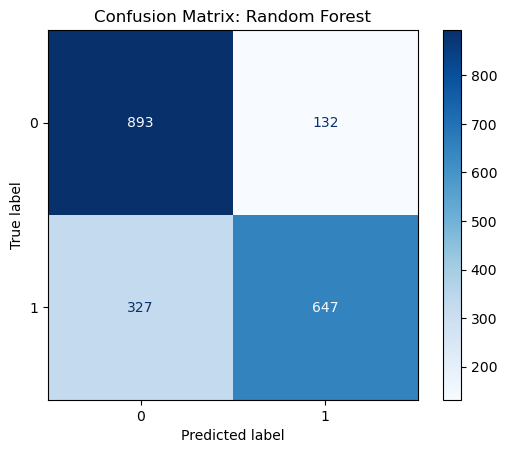

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Random Forest")
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Not Profit       0.73      0.87      0.80      1025
      Profit       0.83      0.66      0.74       974

    accuracy                           0.77      1999
   macro avg       0.78      0.77      0.77      1999
weighted avg       0.78      0.77      0.77      1999

